In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
PATH = './dataset'
IMAGE_SIZE = 32
data = []

In [2]:
tf.random.set_seed(19)
np.random.seed(19)


for file_name in os.listdir(PATH):
    image = tf.keras.preprocessing.image.load_img(PATH + '/' + file_name,
                                                target_size=(IMAGE_SIZE, IMAGE_SIZE))
    image = tf.keras.preprocessing.image.img_to_array(image)
    data.append(image)

data = tf.random.shuffle(data, seed=19)
data = np.array(data)
data = data.astype('float32') / 255.0

train_size = int(len(data) * 0.65)
train_data = data[:train_size]
test_data = data[train_size:]

In [3]:
hidden_dim = 512
latent_dim = 32
epochs = 1000
batch_size = 100
learning_rate = 0.00015

In [4]:
class CVAE(tf.keras.Model):
    def __init__(self, dim, **kwargs):
        h_dim = dim[0]
        z_dim = dim[1]
        super(CVAE, self).__init__(**kwargs)
        self._name = "Convolutional Variational Autoencoder"

        # Encoder
        self.conv = tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', strides=(2, 2), padding='same') # 32 ini  nanti pas uap bisa berubah ikutin soal
        self.conv._name = "encoder_Conv2D"
        self.pool = tf.keras.layers.MaxPool2D((2, 2), padding='same')
        self.pool._name = "encoder_MaxPool2D"
        self.flatten = tf.keras.layers.Flatten()
        self.flatten._name = "encoder_flatten"
        self.fc1 = tf.keras.layers.Dense(h_dim)
        self.fc1._name = "encoder_fc"
        self.fc2_mu = tf.keras.layers.Dense(z_dim)
        self.fc2_mu._name = "encoder_fc_mu"
        self.fc2_log_var = tf.keras.layers.Dense(z_dim)
        self.fc2_log_var._name = "encoder_fc_log_var"

        # Decoder
        self.fc3 = tf.keras.layers.Dense(h_dim, activation='relu')
        self.fc3._name = "decoder_fc"
        self.fc4 = tf.keras.layers.Dense(16 * 16 * 32, activation='relu')
        self.fc4._name = "decoder_fc"
        self.reshape = tf.keras.layers.Reshape((16, 16, 32))
        self.reshape._name = "decoder_reshape"
        self.deconv = tf.keras.layers.Conv2DTranspose(3, kernel_size=(3, 3), strides=(2,2), padding='same')
        self.deconv._name = "decoder_Conv2DTranspose"

    def encode(self, x):
        x = self.conv(x)
        x = self.pool(x)
        x = self.flatten(x)
        h = tf.nn.relu(self.fc1(x))
        return self.fc2_mu(h), self.fc2_log_var(h)

    def reparameterize(self, mu, log_var):
        std = tf.exp(log_var * 0.5)
        eps = tf.random.normal(std.shape)
        return mu + eps * std

    def decode_logits(self, z):
        z = self.fc3(z)
        z = self.fc4(z)
        z = self.reshape(z)
        return self.deconv(z)

    def decode(self, z):
        return tf.nn.sigmoid(self.decode_logits(z))

    def call(self, inputs, training=None, mask=None):
        mu, log_var = self.encode(inputs)
        z = self.reparameterize(mu, log_var)
        x_reconstructed_logits = self.decode_logits(z)
        return x_reconstructed_logits, mu, log_var


model = CVAE([hidden_dim, latent_dim])
X_train = train_data.reshape((-1, IMAGE_SIZE, IMAGE_SIZE, 3))
X_test = test_data.reshape((-1, IMAGE_SIZE, IMAGE_SIZE, 3))

In [5]:
model.build(input_shape=(batch_size, IMAGE_SIZE, IMAGE_SIZE, 3))
print(model.summary())

optimizer = tf.keras.optimizers.Adam(learning_rate)

dataset = tf.data.Dataset.from_tensor_slices(X_train)
dataset = dataset.shuffle(batch_size * 5).batch(batch_size)
num_batches = X_train.shape[0] // batch_size

loss_list = []
kldiv_list = []


Model: "Convolutional Variational Autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_Conv2D (Conv2D)     multiple                  896       
                                                                 
 encoder_MaxPool2D (MaxPool  multiple                  0         
 ing2D)                                                          
                                                                 
 encoder_flatten (Flatten)   multiple                  0         
                                                                 
 encoder_fc (Dense)          multiple                  1049088   
                                                                 
 encoder_fc_mu (Dense)       multiple                  16416     
                                                                 
 encoder_fc_log_var (Dense)  multiple                  16416     
                            

In [6]:
for epoch in range(epochs):
    for step, x in enumerate(dataset):
        x = tf.reshape(x, [-1, IMAGE_SIZE, IMAGE_SIZE, 3])
        with tf.GradientTape() as tape:
            x_reconstruction_logits, mu, log_var = model(x)

            reconstruction_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=x, logits=x_reconstruction_logits)
            reconstruction_loss = tf.reduce_sum(reconstruction_loss) / batch_size
            kl_div = - 0.5 * tf.reduce_sum(1. + log_var - tf.square(mu) - tf.exp(log_var), axis=-1)
            kl_div = tf.reduce_mean(kl_div)

            loss = tf.reduce_mean(reconstruction_loss) + kl_div

        gradients = tape.gradient(loss, model.trainable_variables)
        for g in gradients:
            tf.clip_by_norm(g, 15)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        
        if (step + 1) % 5 == 0:
            loss_list.append(reconstruction_loss)
            kldiv_list.append(kl_div)
            print(
                f"Epoch[{epoch + 1}/{epochs}], Step[{step + 1}/{num_batches}], Reconstruction Loss: {float(reconstruction_loss):.2f}, KL Div: {float(kl_div):.2f}")


Epoch[1/1000], Step[5/5], Reconstruction Loss: 2126.90, KL Div: 0.36
Epoch[2/1000], Step[5/5], Reconstruction Loss: 2122.73, KL Div: 0.34
Epoch[3/1000], Step[5/5], Reconstruction Loss: 2117.76, KL Div: 0.53
Epoch[4/1000], Step[5/5], Reconstruction Loss: 2112.92, KL Div: 0.98
Epoch[5/1000], Step[5/5], Reconstruction Loss: 2104.10, KL Div: 1.25
Epoch[6/1000], Step[5/5], Reconstruction Loss: 2103.59, KL Div: 2.00
Epoch[7/1000], Step[5/5], Reconstruction Loss: 2091.18, KL Div: 2.47
Epoch[8/1000], Step[5/5], Reconstruction Loss: 2085.24, KL Div: 2.78
Epoch[9/1000], Step[5/5], Reconstruction Loss: 2078.24, KL Div: 3.54
Epoch[10/1000], Step[5/5], Reconstruction Loss: 2060.11, KL Div: 4.45
Epoch[11/1000], Step[5/5], Reconstruction Loss: 2063.61, KL Div: 4.96
Epoch[12/1000], Step[5/5], Reconstruction Loss: 2040.77, KL Div: 6.55
Epoch[13/1000], Step[5/5], Reconstruction Loss: 2045.35, KL Div: 6.51
Epoch[14/1000], Step[5/5], Reconstruction Loss: 2003.25, KL Div: 10.59
Epoch[15/1000], Step[5/5], R

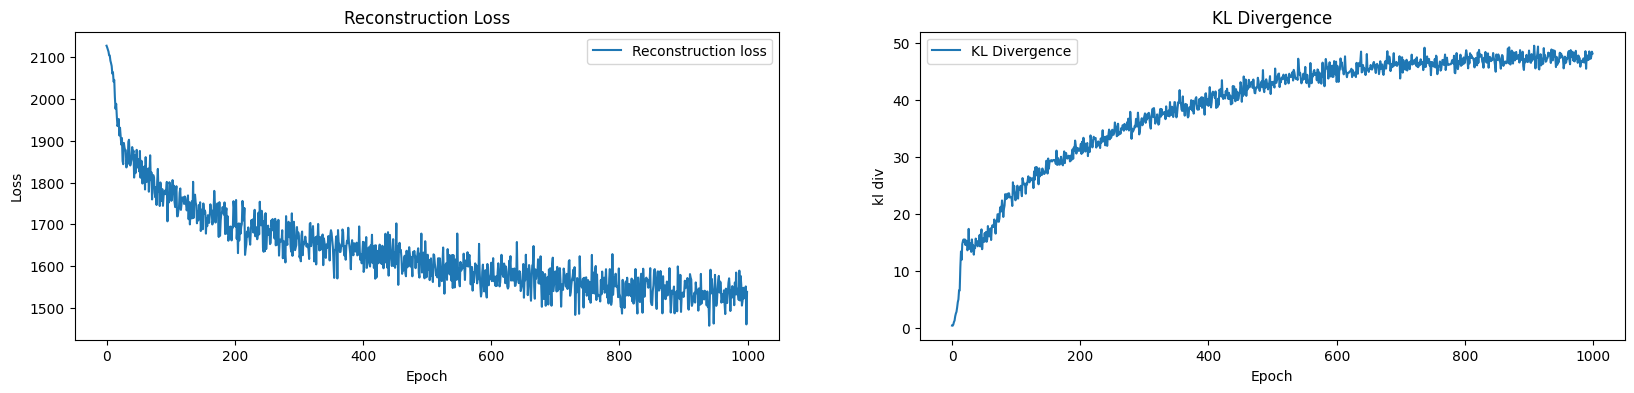

In [7]:
# plot loss and kl div
plt.figure(figsize=(20, 4))
plt.subplot(1, 2, 1)
plt.plot(loss_list, label='Reconstruction loss')
plt.title('Reconstruction Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(kldiv_list, label='KL Divergence')
plt.title('KL Divergence')
plt.ylabel('kl div')
plt.xlabel('Epoch')
plt.legend()
plt.savefig("Loss_KL_Div.png")
plt.show()

(285, 32)
<class '__main__.CVAE'>


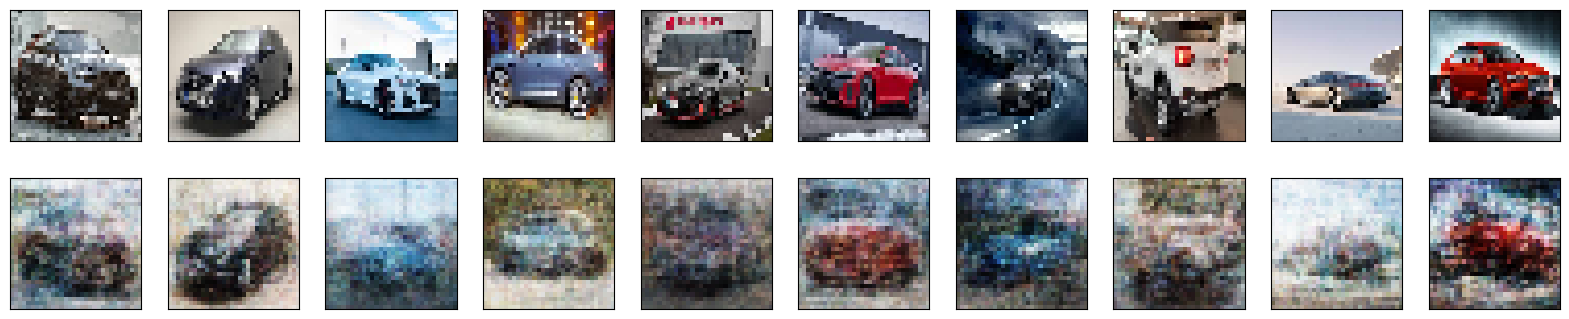

In [8]:
mu, log_var = model.encode(X_test)
print(np.array(mu).shape)
out = model.decode(mu)

print(type(model))
out = tf.reshape(out, [-1, IMAGE_SIZE, IMAGE_SIZE, 3]).numpy() * 255
out = out.astype(np.uint8)

# ini itu jumlah gambar yang nanti di print, jadi ikutin di soal.
number = 10

# Create a single figure with two rows and 'number' columns
# fig, axs = plt.subplots(2, number, figsize=(20, 4))

number = 10
plt.figure(figsize=(20, 4))
for i in range(number):
    ax = plt.subplot(2, number, i+1)
    plt.xlabel("Rec")
    plt.imshow(X_test[i+20], cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
for i in range(number):
    ax = plt.subplot(2, number, i + 11)
    plt.imshow(out[i+20], cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.savefig("Image_Autoencoders.png")
plt.show()